In [868]:
import torch

def generate_skew_symmetric_matrix(p, seed=0):
    torch.manual_seed(seed)
    A = torch.randn(p, p)
    return A - A.T

def transposition_matrix(p, i, j):
    Q = torch.eye(p)
    Q[[i, j], :] = Q[[j, i], :]
    return Q

def extract_submatrix(M, indices):
    return M[indices][:, indices]

# Set dimension and indices to swap
p = 5
i, j = 1, 3  # example transposition indices

# Generate skew-symmetric matrix A and transposition Q
A = generate_skew_symmetric_matrix(p)
Q = transposition_matrix(p, i, j)

# Compute Q^T A Q
A_conjugated = Q.T @ A @ Q

print(A_conjugated + A)
# Extract the 2x2 submatrix on rows and cols {i, j}
submatrix = extract_submatrix(A_conjugated, [i, j])

submatrix + extract_submatrix(A, [i, j])


tensor([[ 0.0000, -2.1666, -3.3885, -2.1666,  0.4613],
        [ 2.1666,  0.0000, -1.9966,  0.0000,  2.6249],
        [ 3.3885,  1.9966,  0.0000,  1.9966,  1.3952],
        [ 2.1666,  0.0000, -1.9966,  0.0000,  2.6249],
        [-0.4613, -2.6249, -1.3952, -2.6249,  0.0000]])


tensor([[0., 0.],
        [0., 0.]])

In [ ]:
import torch

def compute_Gpp(g_prime, g_double_prime, A, Y):
    """
    Compute empirical estimate of G''(0) = E[(Ay)^T g''(y) Ay - g'(y)^T A^T A y]

    Args:
        g_prime: function (N x p) -> (N x p), computes gradient for each sample
        g_double_prime: function (N x p) -> (N x p x p), computes Hessian for each sample
        A: skew-symmetric matrix of shape (p x p)
        Y: data matrix of shape (N x p)

    Returns:
        Estimated G''(0) as a scalar
    """
    A = A.float()
    Y = Y.float()

    AY = Y @ A.T  # (N x p)
    H = g_double_prime(Y)  # (N x p x p)

    # First term: (Ay)^T H (Ay)
    AY_exp = AY.unsqueeze(2)  # (N x p x 1)
    term1 = torch.bmm(torch.bmm(AY.unsqueeze(1), H), AY_exp).squeeze()  # (N,)

    # Second term: g'(y)^T A^T A y
    A2 = A.T @ A
    A2Y = Y @ A2.T
    gY = g_prime(Y)
    term2 = (gY * A2Y).sum(dim=1)  # (N,)
    # print(term1.mean().item(), term2.mean().item())
    term1 = term1.mean().item()
    term2 = term2.mean().item()
    return term1, term2


## SANITY CHECK
# def compute_Gpp_loop(g_prime, g_double_prime, A, Y):
#     """
#     Loop-based version to compute empirical estimate of G''(0) for clarity.
#     Computes G''(0) = E[(Ay)^T g''(y) Ay - g'(y)^T A^T A y] sample by sample.

#     Args:
#         g_prime: function (1 x p) -> (1 x p), gradient function
#         g_double_prime: function (1 x p) -> (1 x p x p), Hessian function
#         A: skew-symmetric matrix of shape (p x p)
#         Y: data matrix of shape (N x p)

#     Returns:
#         Scalar estimate of G''(0)
#     """
#     A = A.float()
#     Y = Y.float()
#     A2 = A.T @ A

#     N = Y.shape[0]
#     total_term1 = 0.0
#     total_term2 = 0.0

#     for i in range(N):
#         y = Y[i].unsqueeze(0)  # (1 x p)
#         Ay = (y @ A.T).squeeze(0)  # (p,)
#         H = g_double_prime(y).squeeze(0)  # (p x p)
#         grad = g_prime(y).squeeze(0)  # (p,)

#         term1 = Ay @ H @ Ay  # scalar
#         term2 = grad @ A2 @ y.squeeze(0)  # scalar

#         total_term1 += term1.item()
#         total_term2 += term2.item()

#     print("Average (Ay)^T H (Ay):", total_term1 / N)
#     print("Average g'(y)^T A^T A y:", total_term2 / N)
#     return (total_term1 - total_term2) / N


In [870]:
from torch.distributions import Dirichlet, Normal

import torch
from torch.distributions.normal import Normal

def mollified_relu_grad(Y, sigma=0.02):
    """
    Compute gradient of mollified ReLU loss w.r.t. Y.
    Y: (N x p), sigma: scalar
    Returns: (N x p) gradient matrix
    """
    normal = Normal(0, 1)
    N, p = Y.shape

    # Negative term gradient
    x = -Y
    grad_neg = normal.cdf(x / sigma)

    # Sum constraint term
    w = Y.sum(dim=1, keepdim=True) - 1  # shape: (N x 1)
    grad_sum = normal.cdf(w / (sigma * p**0.5))  # shape: (N x 1)
    grad_sum_expanded = grad_sum.expand(-1, p)

    return grad_neg + grad_sum_expanded


def mollified_relu_hess(Y, sigma=0.02):
    """
    Compute Hessian of mollified ReLU loss w.r.t. Y.
    Returns (N x p x p) Hessians per sample.
    """
    normal = Normal(0, 1)
    N, p = Y.shape

    # Negative term Hessian (diagonal)
    x = -Y
    diag_vals = normal.log_prob(x / sigma).exp() / sigma  # shape: (N x p)
    H_neg = torch.diag_embed(diag_vals)  # (N x p x p)

    # Sum constraint Hessian (rank-1 update)
    w = Y.sum(dim=1, keepdim=True) - 1  # (N x 1)
    phi_vals = normal.log_prob(w / (sigma * p**0.5)).exp() / (sigma * p**0.5)  # (N x 1)
    ones = torch.ones((N, p, 1), device=Y.device)
    H_sum = phi_vals.view(-1, 1, 1) * torch.bmm(ones, ones.transpose(1, 2))  # (N x p x p)

    return H_neg + H_sum



In [920]:
alpha = torch.tensor([[10, 1, 1], [1, 10, 1]], dtype= torch.float64)
# alpha = torch.tensor([[5, 1]], dtype= torch.float64)
n= 2000
K, p = alpha.shape
sigma = 1
# torch.manual_seed(5)
normal, dir = Normal(0, sigma), Dirichlet(alpha)

X = dir.sample((n // K,)).transpose(0, 1).reshape(n, p)[:, :2]
epsilon = normal.sample((n,p-1))
A = torch.tensor([[0.0, -1.0], [1.0, 0.0]])

# Compute
Gpp_val = compute_Gpp(mollified_relu_grad, mollified_relu_hess, A, epsilon)

print("Estimated G''(0):", Gpp_val)

1.2024412155151367 -0.40817564725875854
Estimated G''(0): 1.610616683959961


In [926]:
sigmas = torch.arange(0.01, 5.01, 0.01, dtype=torch.float64)
gpp_values = []
X = dir.sample((n // K,)).transpose(0, 1).reshape(n, p)[:, :2]

for sigma_val in sigmas:
    normal = Normal(0, sigma_val)
    epsilon = normal.sample((n, p - 1))
    X_noisy = X + epsilon

    Gpp_val = compute_Gpp(
        lambda Y: mollified_relu_grad(Y, sigma=sigma_val),
        lambda Y: mollified_relu_hess(Y, sigma=sigma_val),
        A,
        X_noisy
    )
    gpp_values.append(Gpp_val[0])



7.145758152008057 0.08476477116346359
6.022284030914307 0.14075708389282227
5.25447416305542 0.18818871676921844
4.725024223327637 0.2346750944852829
4.241870880126953 0.2606050968170166
3.820828676223755 0.29124170541763306
3.546884059906006 0.31654199957847595
3.2536191940307617 0.3325408101081848
2.9654700756073 0.3501570522785187
2.8030526638031006 0.35061490535736084
2.6050753593444824 0.3765268623828888
2.4146971702575684 0.3793647289276123
2.2623631954193115 0.39005374908447266
2.145085096359253 0.4145326018333435
2.0224735736846924 0.40707072615623474
1.9527487754821777 0.41567283868789673
1.8468718528747559 0.43986475467681885
1.7470533847808838 0.4143960773944855
1.7196569442749023 0.44614651799201965
1.6475738286972046 0.4503351151943207
1.5999783277511597 0.441171258687973
1.5341718196868896 0.46543705463409424
1.4366345405578613 0.4721742570400238
1.4299496412277222 0.46361663937568665
1.3554160594940186 0.48535940051078796
1.3559283018112183 0.46396711468696594
1.30605649

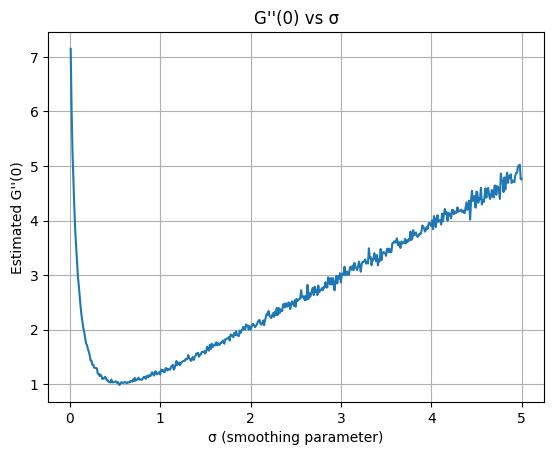

In [927]:
import matplotlib.pyplot as plt

plt.plot(sigmas.numpy(), gpp_values)
plt.xlabel("σ (smoothing parameter)")
plt.ylabel("Estimated G''(0)")
plt.title("G''(0) vs σ")
plt.grid(True)
plt.show()

In [543]:
import torch
from torch.distributions import Dirichlet, Normal
def compute_cross_Gpp(g_double_prime, A1, A2, Y):
    """
    Compute empirical estimate of G_cross''(0) = E[y^T A1^T g''(y) A2 y]

    Args:
        g_double_prime: function (N x p) -> (N x p x p), computes Hessian per sample
        A1: first skew-symmetric matrix (p x p)
        A2: second skew-symmetric matrix (p x p)
        Y: data matrix of shape (N x p)

    Returns:
        Estimated cross term G''(0) = E[y^T A1^T g''(y) A2 y]
    """
    A1 = A1.float()
    A2 = A2.float()
    Y = Y.float()

    AY = Y @ A2.T           # (N x p)
    H = g_double_prime(Y)   # (N x p x p)

    # First term: (A2 y)^T H (A1 y)
    AY_exp = AY.unsqueeze(2)                 # (N x p x 1)
    A1Y = (Y @ A1.T).unsqueeze(1)            # (N x 1 x p)
    term = torch.bmm(A1Y, torch.bmm(H, AY_exp)).squeeze()  # (N,)

    return term.mean().item()


# Define 4D Dirichlet distribution
alpha_4d = torch.tensor([[10.0, 1.0, 1.0, 1.0],
                         [1.0, 10.0, 1.0, 1.0],
                         [1.0, 1.0, 10.0, 1.0],
                         [1.0, 1.0, 1.0, 10.0]], dtype=torch.float64)
dir_4d = Dirichlet(alpha_4d)

# Sampling parameters
n = 200000
K, p = alpha_4d.shape
sigma = 0.02
normal = Normal(0, sigma)

# Sample data
X = dir_4d.sample((n // K,)).transpose(0, 1).reshape(n, p)
epsilon = normal.sample((n, p))
Y = X + epsilon

# Construct two skew-symmetric basis matrices with disjoint support
def skew_basis(p, i, j):
    B = torch.zeros((p, p), dtype=torch.float64)
    B[i, j] = 1.0
    B[j, i] = -1.0
    return B



In [547]:
import numpy as np

def construct_M(p, Y, compute_cross_Gpp, mollified_relu_hess):
    q = (p * (p - 1)) // 2
    M = np.zeros((q, q))
    
    # Map basis index to (i, j)
    index_to_pair = []
    for i in range(p):
        for j in range(i + 1, p):
            index_to_pair.append((i, j))
    
    for a in range(q):
        i, j = index_to_pair[a]
        for b in range(a, q):  # Only need upper triangle due to symmetry
            k, l = index_to_pair[b]
            
            val = compute_cross_Gpp(
                mollified_relu_hess,
                skew_basis(p, i, j),
                skew_basis(p, k, l),
                Y
            )
            M[a, b] = val
            M[b, a] = val  # Symmetry

    return M

In [867]:
import torch
from torch.distributions import Dirichlet, Normal

# Use existing gradient and Hessian functions
def compute_lambda_expectation_term(g_prime, g_double_prime, Y):
    """
    Estimate E[lambda * y_i^2 - g'_i(y) * y_i] using the average eigenvalue of the Hessian.

    Args:
        g_prime: function (N x p) -> (N x p), gradient of loss
        g_double_prime: function (N x p) -> (N x p x p), Hessian of loss
        Y: data matrix (N x p)

    Returns:
        Scalar estimate of E[lambda * y_i^2 - g'_i(y) * y_i]
    """
    N, p = Y.shape
    grad = g_prime(Y)  # (N x p)
    hess = g_double_prime(Y)  # (N x p x p)

    # Mean eigenvalue per sample instead of min
    min_lambdas = torch.linalg.eigvalsh(hess).min(dim=-1).values  # (N,)
    lambda_mean = min_lambdas.mean()  # Scalar
    print(lambda_mean)

    # Pick i = 0 (exchangeability)
    y_i = Y[:, 0]
    grad_i = grad[:, 0]
    lambda_term = lambda_mean * y_i ** 2
    grad_term = grad_i * y_i

    expectation = (lambda_term - grad_term).mean().item()
    return expectation

# Sample Y ~ z + epsilon, with z ~ Dirichlet, epsilon ~ N(0, sigma^2)
def sample_exchangeable_data(n=6000, alpha=None, sigma=0.1, seed=42):
    if alpha is None:
        alpha = torch.tensor([[10.0, 1.0, 1.0], [1.0, 10.0, 1.0], [1.0, 1.0, 10.0]], dtype=torch.float64)
    torch.manual_seed(seed)
    K, p = alpha.shape
    dirichlet = Dirichlet(alpha)
    normal = Normal(0, sigma)

    # Sample z from Dirichlet
    Z = dirichlet.sample((n // K,)).transpose(0, 1).reshape(n, p)

    # Sample epsilon
    epsilon = normal.sample((n, p))

    return Z + epsilon

# Run the experiment
Y = sample_exchangeable_data(n=300, sigma=0.1)
estimate = compute_lambda_expectation_term(mollified_relu_grad, mollified_relu_hess, Y)
estimate


tensor(0.0716, dtype=torch.float64)


-0.15865697015810465

In [632]:
import numpy as np

# Step 1: Define a symmetric matrix H with known eigendecomposition
eigenvalues = np.array([1.0, 2.0, 10.0])
Q = np.linalg.qr(np.random.randn(3, 3))[0]  # random orthonormal matrix
H = Q @ np.diag(eigenvalues) @ Q.T  # symmetric matrix

# Step 2: Define a unit vector y
y = np.array([0.1, 0.2, 0.97])
y = y / np.linalg.norm(y)

# Step 3: Project y onto the eigenbasis
alpha = Q.T @ y  # inner products with eigenvectors

# Step 4: Find the index of the most aligned eigenvector
j = np.argmax(np.abs(alpha))

# Step 5: Remove the aligned eigenvalue and compute min of remaining
remaining_eigenvalues = np.delete(eigenvalues, j)
lambda_perp = np.min(remaining_eigenvalues)

print("Aligned direction index:", j)
print("Removed eigenvalue:", eigenvalues[j])
print("λ_perp(y) =", lambda_perp)


Aligned direction index: 2
Removed eigenvalue: 10.0
λ_perp(y) = 1.0


In [ ]:
import numpy as np
from scipy.linalg import eigh

def lambda_perp(H, y, tol=1e-10):
    """
    Compute the smallest eigenvalue of H restricted to the subspace y⊥.

    Parameters:
    -----------
    H : (p, p) symmetric ndarray
        The Hessian or any real symmetric matrix.
    y : (p,) ndarray
        A nonzero vector (not necessarily unit norm).
    tol : float
        Tolerance for numerical rank cutoff (for Gram-Schmidt).

    Returns:
    --------
    lambda_perp : float
        The smallest eigenvalue of H restricted to y⊥.
    """
    y = y / np.linalg.norm(y)  # ensure unit norm

    # Step 1: Build orthonormal basis for y⊥
    p = len(y)
    basis = []
    for i in range(p):
        v = np.zeros(p)
        v[i] = 1.0
        v = v - y * (y @ v)
        for b in basis:
            v = v - b * (b @ v)
        norm = np.linalg.norm(v)
        if norm > tol:
            basis.append(v / norm)
    Qy = np.stack(basis, axis=1)  # shape: (p, p-1)

    # Step 2: Project H into y⊥
    H_perp = Qy.T @ H @ Qy  # shape: (p-1, p-1)

    # Step 3: Compute minimum eigenvalue
    lambda_min = eigh(H_perp, eigvals_only=True)[0]
    return lambda_min


def generate_H_and_y(p, eigenvalues=None, seed=None):
    """
    Generate a symmetric matrix H with known eigenvalues and a random unit vector y.

    Parameters:
    -----------
    p : int
        Dimension of the matrix and vector.
    eigenvalues : array_like, optional
        Custom eigenvalues for H (must be length p). If None, uses np.linspace(1, p, p).
    seed : int, optional
        Random seed for reproducibility.

    Returns:
    --------
    H : (p, p) ndarray
        Symmetric matrix with known eigenvalues.
    y : (p,) ndarray
        Random unit vector.
    """
    if seed is not None:
        np.random.seed(seed)

    if eigenvalues is None:
        eigenvalues = np.linspace(1.0, float(p), p)  # default: [1.0, 2.0, ..., p]

    eigenvalues = np.array(eigenvalues)
    print(eigenvalues)
    assert len(eigenvalues) == p, "Length of eigenvalues must match dimension p."

    # Generate a random orthonormal basis Q via QR decomposition
    Q, _ = np.linalg.qr(np.random.randn(p, p))

    # Construct H with specified eigenvalues
    H = Q @ np.diag(eigenvalues) @ Q.T

    # Generate random unit vector y
    y = np.random.randn(p)
    y /= np.linalg.norm(y)

    return H, y


In [855]:
H, y = generate_H_and_y(5, np.array([0.01,1,1,4,7]))

print(lambda_perp(H, y))

[0.01 1.   1.   4.   7.  ]
0.029485879471744816
